In [1]:
import numpy as np
import spacy
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import sys
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Read data.
f = open('../DATA1.txt', encoding = "ISO-8859-1")
x = f.readlines()
f.close()

In [3]:
# Parse data into emotions and sentences.
emotion = []
sentences = []

currIdx = 0
for line in x:
    # New entries have a tab \t
    slashIdx = line.find('\t')
    if slashIdx != -1:
        emotion.append(line[0:slashIdx])
        sentences.append(line[slashIdx+2:len(line)-2])
    else:
        sentences[currIdx] += ' ' + line[0:len(line)-2]
        if line.find('"') != -1:
            currIdx += 1

In [4]:
# Initialize tf-idf vectorizer.
tf = TfidfVectorizer(input='sentences_str6.txt', analyzer='word', stop_words = 'english', sublinear_tf=True)
tfidf_matrix =  tf.fit_transform(sentences)
feature_names = tf.get_feature_names()

In [6]:
nlp = spacy.load("en")

# Find mean, max, min sentence vectors by averaging word vectors.
num_sentences = len(sentences)
len_vec = 384
means = np.zeros((num_sentences, len_vec))
maxs = np.zeros((num_sentences, len_vec))
mins = np.zeros((num_sentences, len_vec))
f1 = open("word_vec_tfidf.txt", "w+")
for j in range(len(sentences)):
    # Find tfidf for each word in current sentence.
    feature_index = tfidf_matrix[j,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [tfidf_matrix[j, x] for x in feature_index])
    
    words_idf = []
    tfidf_words = []
    tfidf_idfs = []
    for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
        if ' ' not in w:
            tfidf_words.append(w)
            tfidf_idfs.append(s)
            words_idf.append((w,s))
            
    # Split sentences into tokens.
    sentences_tokens = nlp(sentences[j])
    word_vectors = np.zeros((200,len_vec))
    
    # Add relevant word vectors.
    counter = 0 # For counting number of relevant words
    for k in range(len(sentences_tokens)):
        word = sentences_tokens[k]
        if word.has_vector and (str(word) in tfidf_words):
            word_idx = tfidf_words.index(str(word))
            # Multiply vector by tfidf.
            word_vectors[k,:] = word.vector * tfidf_idfs[word_idx]
            counter += 1
            
    # If none of the words are relevant
    if counter == 0:
        means[j,:] = np.sum(word_vectors, axis=0) 
    else:
        means[j,:] = np.sum(word_vectors, axis=0) / float(counter)
    maxs[j,:] = np.max(word_vectors, axis=0)
    mins[j,:] = np.min(word_vectors, axis=0)

    # Write mean of vectors to file.
    f1.write('[')
    for jj in range(len(means[j])):
        f1.write(str(means[j][jj]) + ', ')
    f1.write(emotion[j] + '],\n')
f1.close()

In [7]:
# Run PCA.
pca = PCA(n_components=2)
sentences_vecs_transformed = pca.fit_transform(means)
sentences_vecs_transformed1 = np.c_[emotion, sentences_vecs_transformed]

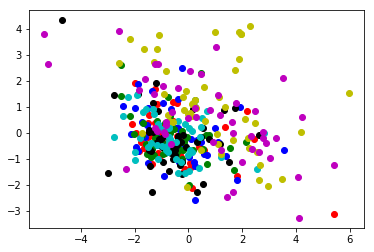

In [8]:
# Plot 50 points from each emotion.
plt.plot(sentences_vecs_transformed[0:50,0], sentences_vecs_transformed[0:50,1], 'ro') # anger
plt.plot(sentences_vecs_transformed[2500:2550,0], sentences_vecs_transformed[2500:2550,1], 'bo') # disgust
plt.plot(sentences_vecs_transformed[3000:3050,0], sentences_vecs_transformed[3000:3050,1], 'go') # fear
plt.plot(sentences_vecs_transformed[3500:3550,0], sentences_vecs_transformed[3500:3550,1], 'ko') # guilt
plt.plot(sentences_vecs_transformed[4000:4050,0], sentences_vecs_transformed[4000:4050,1], 'co') # joy
plt.plot(sentences_vecs_transformed[6000:6050,0], sentences_vecs_transformed[6000:6050,1], 'yo') # sadness
plt.plot(sentences_vecs_transformed[7000:7050,0], sentences_vecs_transformed[7000:7050,1], 'mo') # shame
plt.show()